# 18/10/2020

## Débruitage

Les objectifs de cet exercice sont : 
* appliquer un bruit blanc gaussien au bon RSB sur une image
* implémenter et régler un filtre moyenneur
* implémenter un débruitage par régularisation TV et régler le paramètre de régularisation

Deux méthodes de débruitage sont étudiées dans cette correction : le filtre moyenneur et la régularisation TV.

In [14]:
from scipy.ndimage import convolve

from numpy import sqrt, ones, zeros, arange, argmin, array, inf
from numpy.linalg import norm

from skimage.io import imread
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle


from matplotlib.pyplot import imshow, figure, subplot, title, plot, xlabel, ylabel, ylim, show

Comme il y aura souvent besoin de calculer une EQM, je crée une fonction pour cela :

In [2]:
# Erreur quadratique moyenne (MSE = mean square error)
def mse(a,b):
    M, N = a.shape
    return norm(a-b)**2 / (M*N)

In [3]:
# Calcul de l'écart-type d'un bruit blanc gaussien pour un RSB donné
def stddev(rsb, x):
    return norm(x) / sqrt(M*N) * 10**(-rsb/20)

### Image originale et image bruitée

L'image originale, en niveau de gris :

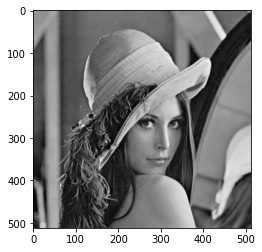

In [4]:
x = imread("lena.tiff")
x = rgb2gray(x)
M, N = x.shape
imshow(x, cmap="gray");

Le rapport signal-à-bruit RSB est défini comme la puissance de l'image $x$ divisée par la puissance du bruit $b$. On choisit généralement une échelle logarithmique :

$$
\mathrm{RSB} = 10 \log_{10} \left(\frac{P_x}{P_b}\right)
\quad\Leftrightarrow\quad
10^\frac{\mathrm{RSB}}{10} = \frac{P_x}{P_b}
$$

avec :

$$
Px = \frac{1}{MN} \sum_{m,n} x(m,n)^2
\quad\text{et}\quad
Pb = \frac{1}{MN} \sum_{m,n} b(m,n)^2 = \sigma^2
$$

Ainsi, d'après la première équation :

$$
                     &P_b = \frac{P_x}{10^\frac{\mathrm{RSB}}{10}} \\
\Leftrightarrow\quad &\sigma^2 = P_x \times 10^{-\frac{\mathrm{RSB}}{10}} \\
\Leftrightarrow\quad &\sigma^2 = \frac{1}{MN} \sum_{m,n} x(m,n)^2 10^{-\frac{\mathrm{RSB}}{10}} \\
$$

Remarquez que $\sqrt{\sum_{m,n}x(m,n)^2}$ correspond à la norme de Frobenius de $x$, qui peut être calculée avec `numpy.linalg.norm`.

Les figures ci-dessous représentent l'image à différents niveaux de bruit.

**Attention :** spécifiez `clip=False` dans l'utilisation de `skimage.util.random_noise`, afin d'ajouter un bruit réellement gaussien !

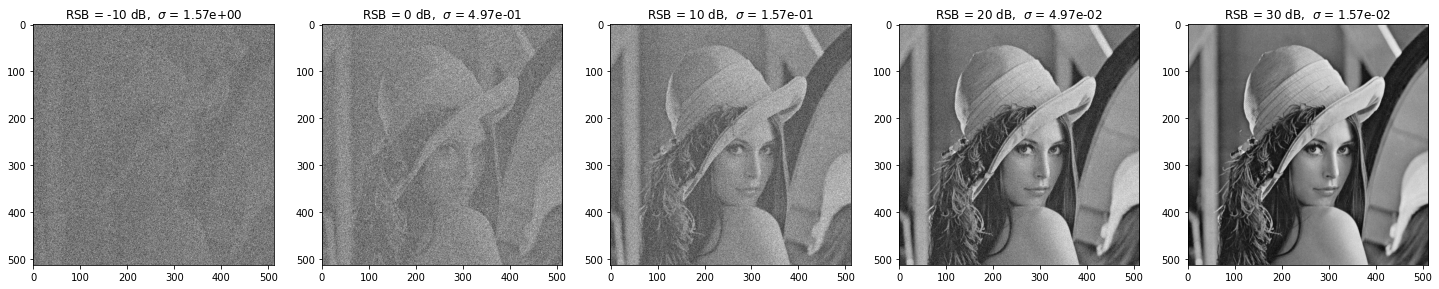

In [5]:
rsbs = [-10, 0, 10, 20, 30]

figure(figsize=(25,10))
i = 0

for rsb in rsbs:
    sigma = stddev(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=sigma**2)
    i = i + 1
    subplot(1,5,i)
    imshow(y, cmap="gray")
    title("RSB = {:.0f} dB,  $\sigma$ = {:.2e}".format(rsb, sigma))    

On remarque bien que plus le RSB est grand, moins le bruit est visible. Cela est logique puisque, dans la définition du RSB, la puissance du bruit apparaît au dénominateur. Par ailleurs, à partir de 30 dB, le bruit devient quasiment invisible, alors qu'en dessous de 0 dB, il est très fort et l'image n'est quasiment plus visible.

### Filtre moyenneur

Je choisis de débruiter l'image avec un RSB égal à 10 dB, et j'applique un filtre moyenneur.

In [6]:
rsb = 10
sigma = stddev(rsb, x)
y = random_noise(x, mode='gaussian', clip=False, var=sigma**2)

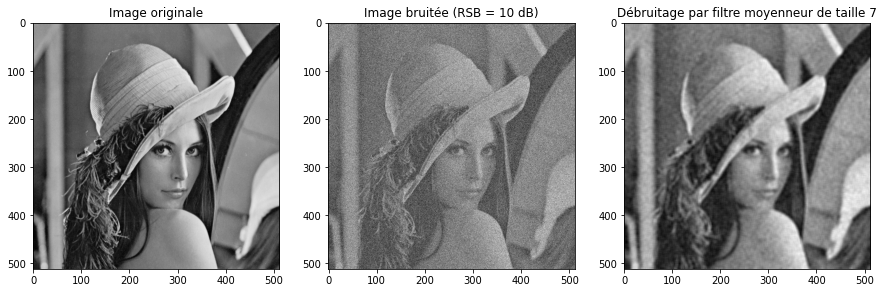

In [7]:
# Exemple d'un filtre moyenneur pour une taille particulière
w = 7
h = ones((w,w)) / (w*w)
xest_mean = convolve(y, h)

# Affichage
figure(figsize=(15,5))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image bruitée (RSB = {} dB)".format(rsb))
subplot(1,3,3)
imshow(xest_mean, cmap="gray")
title("Débruitage par filtre moyenneur de taille {}".format(w));

On observe que le moyennage a permis de diminuer le bruit, ce qui était attendu (avez-vous essayé pour un filtre de taille 1 ? Que se passe-t-il ?). Par contre, l'image est plus floue : les contours sont moins nets. Cette seconde observation s'explique puisque le filtre moyenneur correspond à une convolution par un noyau qui n'est pas impulsionnel : il y a donc un étalement des intensités des pixels les uns sur les autres.

Une mesure quantitative permettant de mesurer la qualité du débruitage est de calculer l'EQM entre l'image débruitée $\hat{x}$ et $x$. Ainsi, le débruitage permettra d'améliorer l'EQM, mais dans le même temps le flou introduit va dégrader l'EQM. En conséquence, on peut s'attendre à ce que l'EQM évolue en fonction de la taille `w` du filtre. Pour vérifier cette hypothèse, on peut tracer les valeurs que prend l'EQM pour différentes valeurs de `w` :

La meilleure restauration est obtenue pour w = 5 et correspond à une EQM = 2.180881e-03


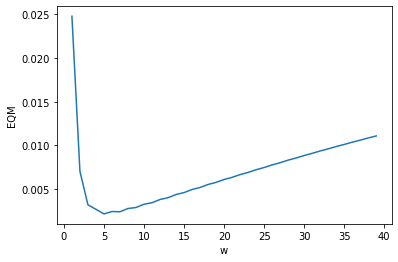

In [8]:
# Évolution de l'EQM en fonction de la taille du filtre
ws = arange(1,40)
eqm = zeros(ws.shape)
for i, w in enumerate(ws):
    h = ones((w,w)) / (w*w)
    xest = convolve(y, h)
    eqm[i] = mse(x, xest)
plot(ws, eqm)
xlabel('w')
ylabel('EQM')

i = argmin(eqm)
eqm = eqm[i]
w = ws[i]
print("La meilleure restauration est obtenue pour w = {:.0f} et correspond à une EQM = {:e}".format(w,eqm))

Comme nous pouvions nous y attendre, l'EQM évolue bien en fonction de la taille du filtre moyenneur. Il faut donc faire un compromis entre la capacité de débruitage et le flou introduit par le filtre. On observe quand même que la courbe présente un minimum : cela correspond à l'EQM la plus faible qui est obtenue, ici pour `w`=5.

Malheureusement, il n'y a pas de moyen simple de connaître a priori la meilleur taille du filtre moyenneur à partir du RSB. La valeur obtenue ici dépend également de l'image (essayez avec une autre image !).

### Débruitage TV

Sur l'image bruitée à RSB = 10 dB, on effectue maintenant un débruitage par régularisation TV (_total variation_).

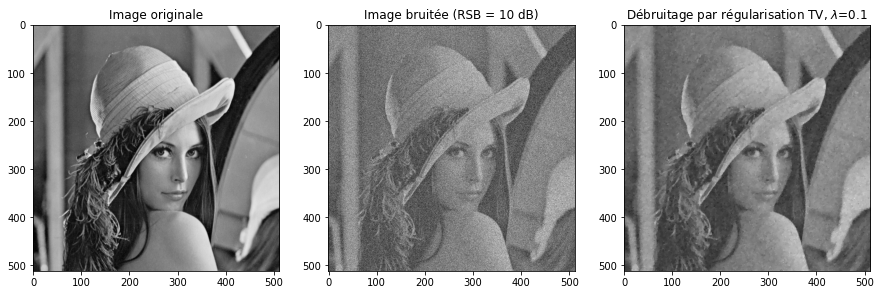

In [9]:
# Exemple
lbd = 0.1
xest_tv = denoise_tv_chambolle(y, weight=lbd)

# Affichage
figure(figsize=(15,5))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image bruitée (RSB = {} dB)".format(rsb))
subplot(1,3,3)
imshow(xest_tv, cmap="gray")
title("Débruitage par régularisation TV, $\lambda$={}".format(lbd));

Comme avec le filtre moyenneur, on observe que l'image est bien débruitée (le bruit est plus faible, donc l'EQM sera meilleure), mais que certains détails de l'image, comme les yeux, sont modifiés, ce qui aura pour conséquence de dégrader l'EQM. On peut donc s'attendre, comme précédemment, à ce qu'il existe une valeur optimale du paramètre de régularisation $\lambda$. Reste à savoir si cette technique de débruitage pourra dépasser les performances du filtre moyenneur...

La meilleure restauration est obtenue pour lambda = 0.16 et correspond à une EQM = 1.573617e-03


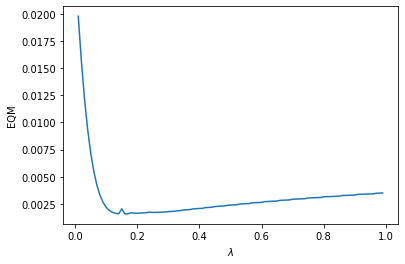

In [10]:
# Évolution de l'EQM en fonction de la taille du filtre
lbds = arange(0.01, 1, 0.01)
eqm = zeros(lbds.shape)
for i, lbd in enumerate(lbds):
    xest = denoise_tv_chambolle(y, weight=lbd)
    eqm[i] = mse(x, xest)
plot(lbds, eqm)
xlabel('$\lambda$')
ylabel('EQM')

i = argmin(eqm)
eqm = eqm[i]
lbd = lbds[i]
print("La meilleure restauration est obtenue pour lambda = {:.2f} et correspond à une EQM = {:e}".format(lbd,eqm))

La courbe a le même type de comportement que dans le cas du filtre moyenneur : il existe une valeur optimale du paramètre de la méthode pour laquelle l'EQM est meilleure. Ici, on a $\lambda=0,16$.

À y regarder de plus près, on remarque que la meilleure EQM a une valeur plus faible que la meilleur EQM obtenue dans le cas du filtre moyenneur. Conclusion : le débruitage par régularisation TV est plus performant que le filtre moyenneur !
Mais attention : cette conclusion est partielle, car obtenue seulement pour l'image lena.tiff avec un RSB de 10 dB.

### Comparaison des deux méthodes de débruitage pour différents RSB

En calculant, pour plusieurs valeurs de RSB, les meilleurs paramètres pour les deux méthodes, on peut analyser l'évolution de l'EQM en fonction du niveau de bruit de l'image.

In [11]:
rsbs = arange(-5, 20, 2)

# Filtre moyenneur
ws = arange(1,40)
mean_eqm = zeros(rsbs.shape)
mean_w = zeros(rsbs.shape)

# Régularisation TV
lbds = arange(0.01, 1, 0.01)
tv_eqm = zeros(rsbs.shape)
tv_lbd = zeros(rsbs.shape)

for i, rsb in enumerate(rsbs):
    
    # Génération de l'image bruitée
    sigma = stddev(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=sigma**2)

    # Filtre moyenneur
    besteqm = inf
    for w in ws:
        h = ones((w,w)) / (w*w)
        xest = convolve(y, h)
        eqm = mse(x, xest)
        if eqm < besteqm:
            besteqm = eqm
            bestw = w
    mean_eqm[i] = besteqm
    mean_w[i] = bestw
    
    # Débruitage TV
    besteqm = inf
    for lbd in lbds:
        xest = denoise_tv_chambolle(y, weight=lbd)
        eqm = mse(x, xest)
        if eqm < besteqm:
            besteqm = eqm
            bestlbd = lbd
    tv_eqm[i] = besteqm
    tv_lbd[i] = bestlbd

On peut alors représenter l'évolution de l'EQM pour les deux méthodes :

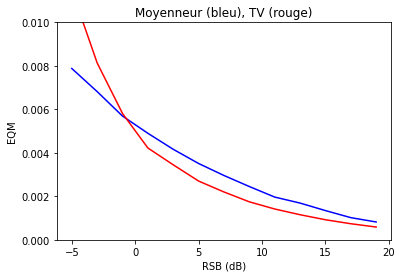

In [12]:
plot(rsbs, mean_eqm, 'b')
plot(rsbs, tv_eqm, 'r')
ylim(0, 0.010)
title("Moyenneur (bleu), TV (rouge)")
xlabel("RSB (dB)")
ylabel("EQM");

On observe une décroissance de l'EQM en fonction du RSB. Cela s'interprète par le fait lorsque le bruit diminue, l'image débruitée ressemble de plus en plus à la vérité terrain, ce qui est tout à fait logique.

Par ailleurs, on observe que :
* pour des RSB inférieurs à (environ) 0 dB, le filtre moyenneur est meilleur que la régularisation TV. Cela peut paraître surprenant puisque la régularisation TV est censée être meilleure, c'est d'ailleurs ce qu'on a pu vérifier ci-avant. Cependant, un RSB inférieur à 0 dB est extrêmement faible. En fait, aucune des deux méthodes ne donne un résultat réellement satisfaisant (voir ci-après)
* pour des images à RSB supérieurs à 0 dB, la régularisation TV est meilleure.

Observons maintenant l'évolution des valeurs des meilleurs paramètres des deux méthodes, en fonction du RSB :

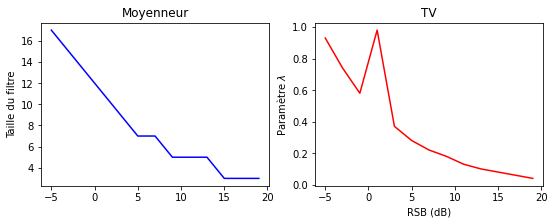

In [18]:
figure(figsize=(9,3))
subplot(1,2,1)
plot(rsbs, mean_w, 'b')
ylabel('Taille du filtre')
title("Moyenneur")
subplot(1,2,2)
plot(rsbs, tv_lbd, 'r')
xlabel("RSB (dB)");
ylabel('Paramètre $\lambda$')
title("TV")
show()

Pour les deux méthodes, la valeur du paramètre décroît lorsque le RSB augmente.
* pour le filtre moyenneur (en bleu), la fenêtre utilisée est donc de plus en plus petite lorsque le bruit diminue. C'est logique : le bruit diminuant, il n'est pas nécessaire de moyenner sur un grand voisinage, ce qui permet de trop flouter l'image.
* pour la régularisation TV (rouge), le paramètre de régularisation est plus faible lorsque le bruit diminue. C'est également logique : en diminuant, le paramètre de régularisation donne moins de poids à la régularisation qui est là surtout pour compenser le bruit. S'il y a moins de bruit, il y a moins besoin de régulariser !

On peut vérifier que ces conclusions sont en accord avec ce qu'on peut observer sur quelques exemples :

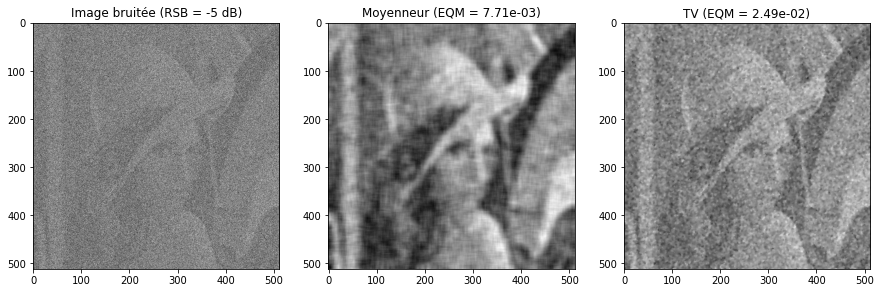

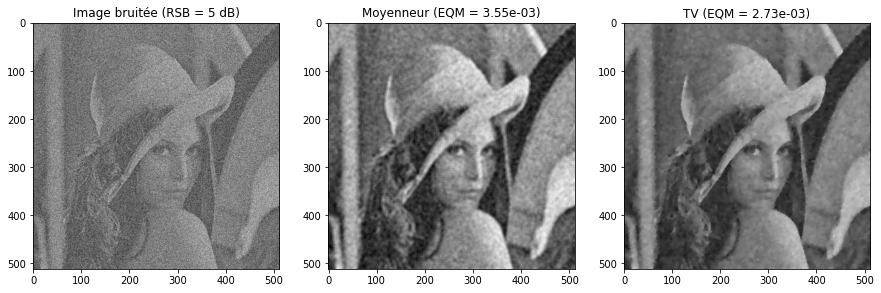

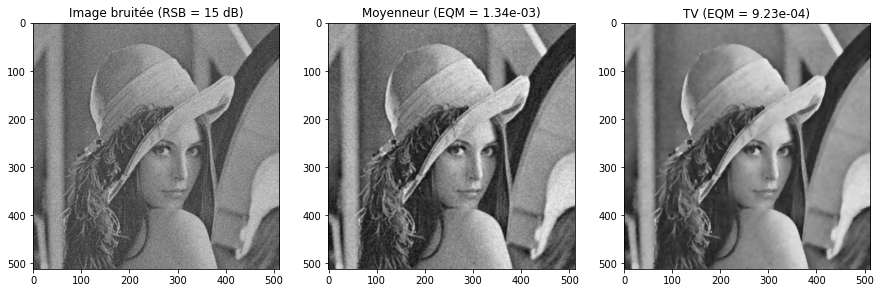

In [19]:
idx = [0, 5, 10]

for i in idx:
    
    rsb = rsbs[i]
    
    # Génération de l'image bruitée
    sigma = stddev(rsb, x)
    y = random_noise(x, mode='gaussian', clip=False, var=sigma**2)

    # Filtre moyenneur
    w = int(mean_w[i])
    h = ones((w,w)) / (w*w)
    xest_mean = convolve(y, h)
    eqm_mean = mse(x, xest_mean)
    
    # Débruitage TV
    lbd = tv_lbd[i]
    xest_tv = denoise_tv_chambolle(y, weight=lbd)
    eqm_tv = mse(x, xest_tv)
    
    # Affichage
    figure(figsize=(15,15))
    subplot(1,3,1)
    imshow(y, cmap="gray")
    title("Image bruitée (RSB = {} dB)".format(rsb))
    subplot(1,3,2)
    imshow(xest_mean, cmap="gray")
    title("Moyenneur (EQM = {:.2e})".format(eqm_mean))
    subplot(1,3,3)
    imshow(xest_tv, cmap="gray")
    title("TV (EQM = {:.2e})".format(eqm_tv))

OK, on retrouve les mêmes conclusions que précédemment.

La comparaison entre ces deux méthodes n'a été effectuée que sur une seule image et un seul critère (la qualité du résultat en termes d'EQM). C'est sans doute le meilleur critère pour comparer deux méthodes, mais d'autres points de comparaison existent, comme par exemple la complexité de la méthode, le temps de calcul, etc.

## Déconvolution

Les objectifs de cet exercice sont : 
* savoir appliquer une dégradation connue sur une image
* comprendre pourquoi la déconvolution naïve ne fonctionne pas
* implémenter un filtre de Wiener

In [20]:
# Ne pas utiliser scipy.ndimage.convolve (qui ne permet pas de faire de convolution circulante)
from scipy.ndimage.filters import convolve

from numpy import sqrt, ones, zeros, absolute, log, real, arange, argmin
from numpy.linalg import norm
from numpy.fft import fft2, ifft2, fftshift

from skimage.io import imread
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.restoration import wiener

from matplotlib.pyplot import imshow, show, title, figure, subplot, plot, xlabel, ylabel

In [21]:
# Erreur quadratique moyenne
def mse(a,b):
    M, N = a.shape
    return norm(a-b)**2 / (M*N)

In [22]:
# Calcul de l'écart-type d'un bruit blanc gaussien pour un RSB donné
def stddev(x, rsb):
    M, N = x.shape
    return norm(x) / sqrt(M*N) * 10**(-rsb/20)

### Images originale et floutée

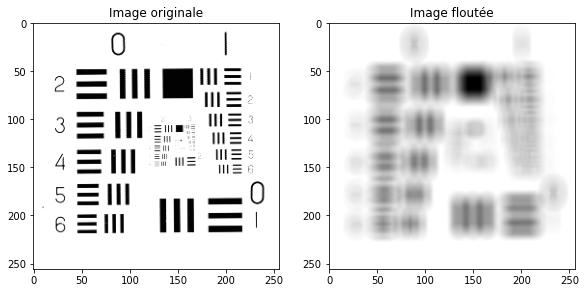

In [23]:
# TODO : montrer sur un Dirac ?
# x = zeros((49,49))
# x[24,24] = 1

# Image originale x
x = imread("chart.tiff")
x = x.astype(float) # Attention : convertir en float !

# Image floutée w
L = 10
h = disk(L)
y = convolve(x, h, mode="wrap")

# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image floutée");

La mire « USAF 1951 » est un outil pour mesurer la résolution d'instruments optiques. Elle a été conçu par l'U.S. Air Force. Son intérêt en traitement d'images est de mesurer la capacité de résolution des méthodes. Ici, elle est intéressante car une fois floutée, il est difficile de comptabiliser les lignes et de lire les chiffres.

### Filtre inverse sur l'image sans bruit

In [24]:
# Notez qu'il n'est pas nécessaire ici d'utiliser fftshift.
Y = fft2(y)
H = fft2(h, Y.shape)     # Attention, pour pouvoir diviser les deux FFT, elles doivent être de la même taille !
Xest = Y/H
xest = real(ifft2(Xest)) # Attention, bien prendre la partie réelle !

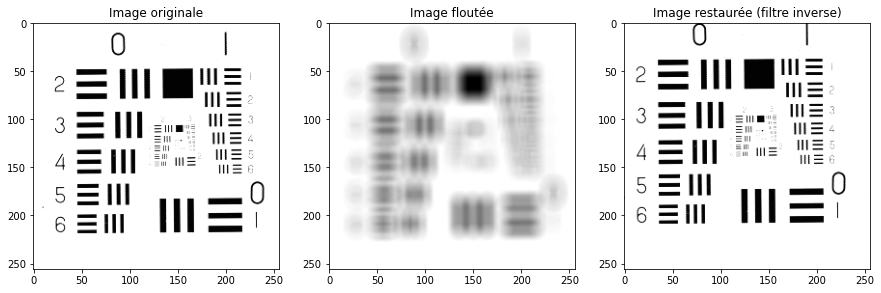

In [25]:
# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image floutée")
subplot(1,3,3)
imshow(xest, cmap="gray")
title("Image restaurée (filtre inverse)")
show()

En l'absence de bruit, le filtre inverse fonctionne parfaitement (à l'exception d'un décalage).

### Filtre inverse avec bruit

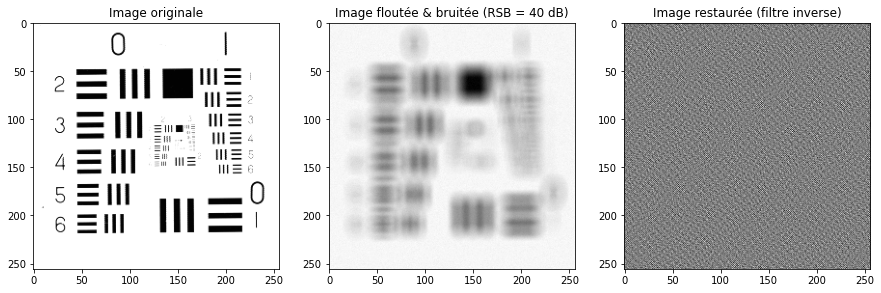

In [26]:
# Image floutée + bruitée y
rsb = 40
sigma = stddev(y, rsb)
y = random_noise(y, mode='gaussian', clip=False, var=sigma**2)

# Filtrage inverse
Y = fft2(y)
H = fft2(h, Y.shape)
Xest = Y/H
xest = real(ifft2(Xest))

# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image floutée & bruitée (RSB = {} dB)".format(rsb))
subplot(1,3,3)
imshow(xest, cmap="gray")
title("Image restaurée (filtre inverse)")
show()

En revanche, lorsque l'image est bruitée (même faiblement : ici le RSB est de 40 dB), la restauration n'est pas du tout acceptable !

### Filtre de Wiener avec bruit

Attention, il existe une autre fonction `wiener` (`skimage.filters.wiener`), mais elle est plus délicate à utiliser. Utilisez plutôt `skimage.restoration.wiener`, en n'oubliant pas l'argument `clip=False`.

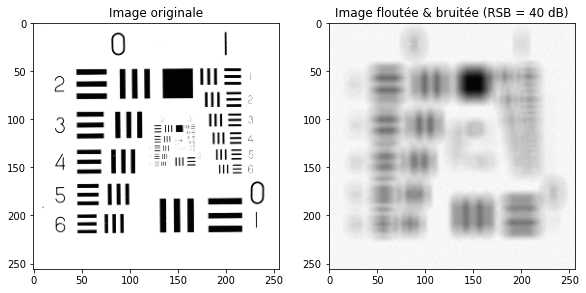

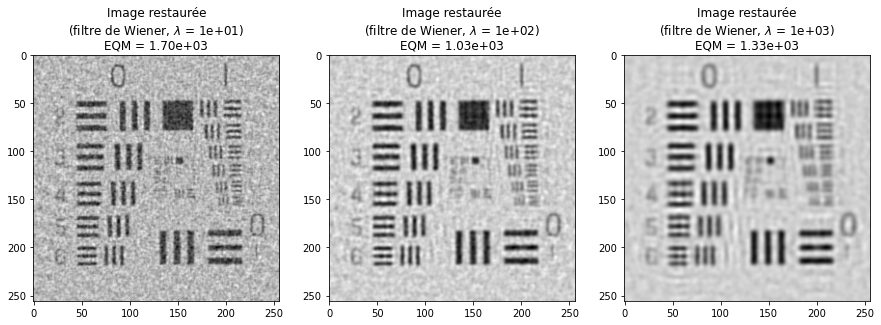

In [27]:
# Affichage
figure(figsize=(15,10))
subplot(1,3,1)
imshow(x, cmap="gray")
title("Image originale")
subplot(1,3,2)
imshow(y, cmap="gray")
title("Image floutée & bruitée (RSB = {} dB)".format(rsb))
show()

figure(figsize=(15,10))
lbds = [1e1, 1e2, 1e3]
for i, lbd in enumerate(lbds):
    xest = wiener(y, h, lbd, clip=False) # Attention : clip = False
    eqm = mse(x, xest)
    subplot(1,3,1+i)
    imshow(xest, cmap="gray")
    title("Image restaurée\n(filtre de Wiener, $\lambda$ = {:.0e})\nEQM = {:.2e}".format(lbd,eqm))

Ces premiers résultats, pour trois valeurs du paramètre $\lambda$, permettent de montrer qu'en termes d'EQM, il y a un compromis à faire entre la puissance du débruitage et la conservation de l'image originale. Si $\lambda$ est trop faible, l'image restaurée est bien déconvoluée mais reste très bruitée ; si $\lambda$ est trop grand alors l'image reste floue.

Pour une meilleure analyse, nous alons représenter l'évolution de l'EQM en fonction de $\lambda$ (comme dans l'exercice 1).

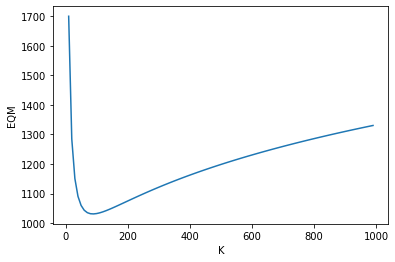

La meilleure restauration est obtenue pour lambda = 90 et correspond à une EQM = 1031.34.


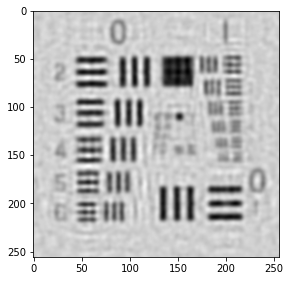

In [28]:
lbds = arange(1e1, 1e3, 1e1)
eqm = zeros(lbds.shape)
for i, lbd in enumerate(lbds):
    xest = wiener(y, h, lbd, reg=None, is_real=True, clip=False)
    eqm[i] = mse(x, xest)

# Évolution de l'EQM
plot(lbds,eqm)
xlabel("K")
ylabel("EQM")
show()

# Meilleure restauration
i = argmin(eqm)
eqm = eqm[i]
lbd = lbds[i]
print("La meilleure restauration est obtenue pour lambda = {:.0f} et correspond à une EQM = {:.2f}.".format(lbd,eqm))

figure(figsize=(15,10))
subplot(2,3,1)
imshow(xest, cmap="gray");

Personnellement, je trouve que cette valeur de $\lambda$ fournit une image moins claire que pour des valeurs de $\lambda$ plus faibles (comme celles présentées plus haut). Cela montre que l'EQM ne représente pas parfaitement la qualité perçue. Mais contrairement à la qualité perçue qui peut être subjective ou dépendre de l'objectif souhaité, l'EQM est une mesure objective et quantitative.

Cela dit, la déconvolution a tout de même joué son rôle : les lignes et les chiffres sont lisibles, contrairement à l'image observée.

Enfin, et comme pour les méthodes de débruitage de l'exercice 1, il est très difficile de fixer a priori la valeur du paramètre $\lambda$.